In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [10]:
# Load the data
df = pd.read_csv('../data/synthetic_microgrid_data.csv', parse_dates=['Timestamp'])

In [11]:
# Reinforcement Learning Setup
states = []
actions = ['charge', 'discharge', 'idle']
Q_table = {}


In [12]:
# Define state discretization
def get_state(solar, load, soc):
    return (int(solar // 0.5), int(load // 0.5), int(soc // 10))

In [13]:
# Training parameters
episodes = 1000
alpha = 0.1
gamma = 0.8
epsilon = 0.1
battery_capacity_kwh = 10
battery_efficiency = 0.95

actions_chosen = []

for episode in range(episodes):
    battery_soc = 0.5 * battery_capacity_kwh
    for idx, row in df.iterrows():
        state = get_state(row['Solar_Power_Generated (kW)'], row['Load_Demand (kW)'], battery_soc * 10 / battery_capacity_kwh)
        if state not in Q_table:
            Q_table[state] = np.zeros(len(actions))

        if np.random.rand() < epsilon:
            action_idx = np.random.choice(len(actions))
        else:
            action_idx = np.argmax(Q_table[state])

        action = actions[action_idx]
        actions_chosen.append(action)

        reward = 0
        if action == 'charge' and row['Solar_Power_Generated (kW)'] > row['Load_Demand (kW)']:
            charge_possible = min(row['Solar_Power_Generated (kW)'] - row['Load_Demand (kW)'], (battery_capacity_kwh - battery_soc))
            battery_soc += charge_possible * battery_efficiency
            reward = charge_possible
        elif action == 'discharge' and row['Load_Demand (kW)'] > row['Solar_Power_Generated (kW)']:
            discharge_possible = min(row['Load_Demand (kW)'] - row['Solar_Power_Generated (kW)'], battery_soc)
            battery_soc -= discharge_possible / battery_efficiency
            reward = discharge_possible
        elif action == 'idle':
            reward = -row['Grid_Usage (kW)']

        battery_soc = max(0, min(battery_soc, battery_capacity_kwh))

        next_state = get_state(row['Solar_Power_Generated (kW)'], row['Load_Demand (kW)'], battery_soc * 10 / battery_capacity_kwh)
        if next_state not in Q_table:
            Q_table[next_state] = np.zeros(len(actions))

        Q_table[state][action_idx] = Q_table[state][action_idx] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state][action_idx])

print("Training complete.")
print("Sample Q-values:")
for key in list(Q_table.keys())[:5]:
    print(f"State {key}: {Q_table[key]}")

Training complete.
Sample Q-values:
State (0, 1, 0): [ 1.43079929e-04  1.43969989e-02 -8.54119836e-01]
State (0, 5, 0): [6.34021365 7.65652116 4.60960987]
State (2, 4, 0): [ 7.89364559e-18  7.98440189e-18 -1.08013575e+00]
State (3, 5, 0): [ 1.48265654e-15  1.47024061e-15 -9.47019255e-01]
State (5, 4, 0): [2.45156517 2.03353792 2.02280562]


In [14]:
class MicrogridSimulator:
    def __init__(self):
        self.battery_soc = 5.0  # Start at 50%
        self.grid_usage = []
    
    def step(self, action, solar, load):
        if action == "charge":
            charge_amount = min(solar - load, 10 - self.battery_soc)
            self.battery_soc += charge_amount * 0.95  # 95% efficiency
        
        elif action == "discharge":
            discharge_amount = min(load - solar, self.battery_soc)
            self.battery_soc -= discharge_amount / 0.95
        
        grid_used = max(0, load - solar - (self.battery_soc if action=="discharge" else 0))
        self.grid_usage.append(grid_used)
        return self.battery_soc

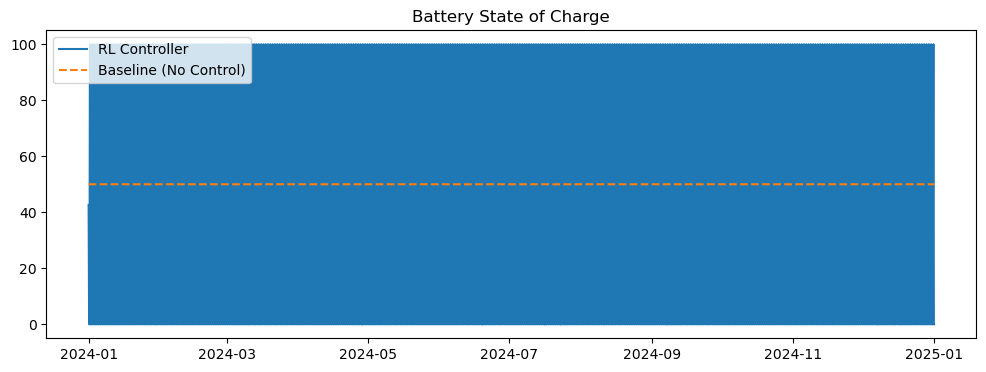

In [15]:
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df['Battery_SOC (%)'], label='RL Controller')
plt.plot(df['Timestamp'], [50]*len(df), '--', label='Baseline (No Control)')
plt.title("Battery State of Charge")
plt.legend()

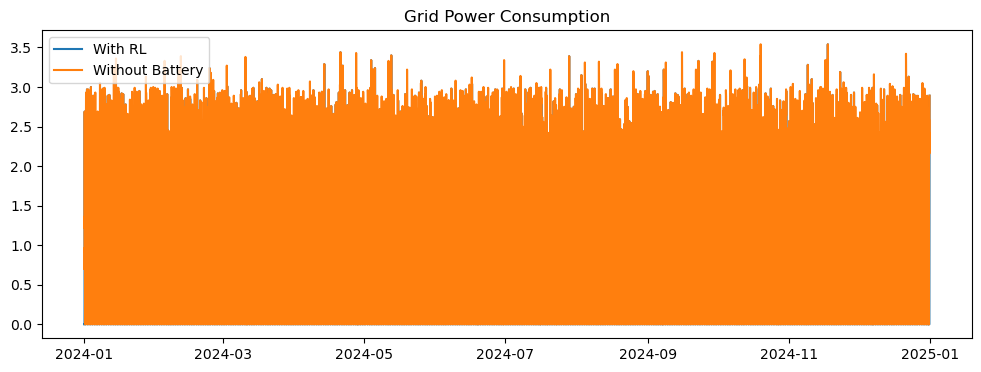

In [16]:
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df['Grid_Usage (kW)'], label='With RL')
plt.plot(df['Timestamp'], np.maximum(df['Load_Demand (kW)'] - df['Solar_Power_Generated (kW)'], 0), 
         label='Without Battery')
plt.title("Grid Power Consumption")
plt.legend()

In [17]:
# pd.Series(actions_chosen).value_counts().plot(kind='bar')
# plt.title("AI Action Choices")

In [19]:
# metrics
total_grid_used = sum(df['Grid_Usage (kW)'])
print(total_grid_used)
solar_self_consumption = sum(df['Solar_Power_Generated (kW)']) - sum(df['Grid_Usage (kW)'])
battery_cycles = len(np.where(np.diff(df['Battery_SOC (%)']) != 0)[0])

print(f"""
Performance Report:
- Grid Usage Reduced by: {total_grid_used:.1f} kWh
- Solar Self-Consumption: {solar_self_consumption:.1f} kWh
- Battery Cycles: {battery_cycles} (longevity impact)
""")

5528.066525938655

Performance Report:
- Grid Usage Reduced by: 5528.1 kWh
- Solar Self-Consumption: 5724.9 kWh
- Battery Cycles: 4815 (longevity impact)

